In [1]:
# Imports:

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
import numpy as np
import glob
import os 

from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils

In [ ]:
# Initialize directory path variable:

store_image = []
train_path = './train'
fps = 5
train_videos = os.listdir('D:\\Dataset\\Train')
train_images_path = train_path+'/frames'
os.makedirs(train_images_path)

# Describe a function to process and store video frames:

def store_inarray(image_path):
    image = load_img(image_path)
    image = img_to_array(image)
    image = cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
    gray = 0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]
    store_image.append(gray)

In [4]:
# Extract frames from video and call store function:

for video in train_videos:
        os.system( 'ffmpeg -i {}/{} -r 1/{}  {}/frames/%03d.jpg'.format(train_path,video,fps,train_path))
        images = os.listdir(train_images_path)
        for image in images:
            image_path = framepath+ '/'+ image
            store_inarray(image_path)

In [ ]:
# Store the "store_image" list in a numpy file called “training.npy”:

store_image = np.array(store_image)
a,b,c = store_image.shape

# Data Normalization
store_image.resize(b,c,a)
store_image = (store_image-store_image.mean())/(store_image.std())
store_image = np.clip(store_image,0,1)
np.save('training.npy',store_image)

In [6]:
# Create spatial autoencoder architecture (Layers):

stae_model = Sequential()
stae_model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
stae_model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

stae_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [7]:
#  Train the autoencoder on the “training.npy” file:

training_data = np.load('training.npy')
frames = training_data.shape[2]
frames = frames-frames%10

training_data = training_data[:,:,:frames] # Train Data
training_data = training_data.reshape(-1,227,227,10)
training_data = np.expand_dims(training_data,axis=4)
target_data = training_data.copy() # Test Data

epochs = 1000
batch_size = 1

callback_save = ModelCheckpoint("model.h5",
monitor = "loss_error", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor = 'val_loss', patience=3)


history = stae_model.fit(training_data,target_data,
          batch_size = batch_size,
          epochs = epochs,
          callbacks = [callback_save,callback_early_stopping]
          )

# Save the model with name “model.h5”:

stae_model.save("model.h5")

Epoch 1/1000
10/10 [==============================] - 9s 548ms/step - loss: 0.2523 - accuracy: 0.5749
Epoch 2/1000
10/10 [==============================] - 5s 545ms/step - loss: 0.2186 - accuracy: 0.5809
Epoch 3/1000
10/10 [==============================] - 6s 561ms/step - loss: 0.2174 - accuracy: 0.6022
Epoch 4/1000
10/10 [==============================] - 6s 577ms/step - loss: 0.2053 - accuracy: 0.5961
Epoch 5/1000
10/10 [==============================] - 6s 575ms/step - loss: 0.1995 - accuracy: 0.5692
Epoch 6/1000
10/10 [==============================] - 6s 568ms/step - loss: 0.1928 - accuracy: 0.6030
Epoch 7/1000
10/10 [==============================] - 6s 584ms/step - loss: 0.1955 - accuracy: 0.5959
Epoch 8/1000
10/10 [==============================] - 6s 590ms/step - loss: 0.1903 - accuracy: 0.5736
Epoch 9/1000
10/10 [==============================] - 6s 571ms/step - loss: 0.2044 - accuracy: 0.5870
Epoch 10/1000
10/10 [==============================] - 6s 577ms/step - loss: 0.190

10/10 [==============================] - 6s 588ms/step - loss: 0.0395 - accuracy: 0.8531
Epoch 160/1000
10/10 [==============================] - 6s 585ms/step - loss: 0.0387 - accuracy: 0.8534
Epoch 161/1000
10/10 [==============================] - 6s 588ms/step - loss: 0.0390 - accuracy: 0.8525
Epoch 162/1000
10/10 [==============================] - 6s 581ms/step - loss: 0.0398 - accuracy: 0.8523
Epoch 163/1000
10/10 [==============================] - 6s 586ms/step - loss: 0.0394 - accuracy: 0.8526
Epoch 164/1000
10/10 [==============================] - 6s 581ms/step - loss: 0.0385 - accuracy: 0.8540
Epoch 165/1000
10/10 [==============================] - 6s 583ms/step - loss: 0.0380 - accuracy: 0.8539
Epoch 166/1000
10/10 [==============================] - 6s 586ms/step - loss: 0.0377 - accuracy: 0.8542
Epoch 167/1000
10/10 [==============================] - 6s 585ms/step - loss: 0.0368 - accuracy: 0.8549
Epoch 168/1000
10/10 [==============================] - 6s 589ms/step - loss: 0

10/10 [==============================] - 6s 586ms/step - loss: 0.0234 - accuracy: 0.8686
Epoch 316/1000
10/10 [==============================] - 6s 600ms/step - loss: 0.0234 - accuracy: 0.8686
Epoch 317/1000
10/10 [==============================] - 6s 592ms/step - loss: 0.0234 - accuracy: 0.8683
Epoch 318/1000
10/10 [==============================] - 6s 588ms/step - loss: 0.0250 - accuracy: 0.8675
Epoch 319/1000
10/10 [==============================] - 6s 593ms/step - loss: 0.0239 - accuracy: 0.8681
Epoch 320/1000
10/10 [==============================] - 6s 590ms/step - loss: 0.0240 - accuracy: 0.8680
Epoch 321/1000
10/10 [==============================] - 6s 643ms/step - loss: 0.0238 - accuracy: 0.8682
Epoch 322/1000
10/10 [==============================] - 7s 652ms/step - loss: 0.0237 - accuracy: 0.8681
Epoch 323/1000
10/10 [==============================] - 6s 627ms/step - loss: 0.0243 - accuracy: 0.8680
Epoch 324/1000
10/10 [==============================] - 6s 582ms/step - loss: 0

10/10 [==============================] - 6s 595ms/step - loss: 0.0179 - accuracy: 0.8722
Epoch 472/1000
10/10 [==============================] - 6s 591ms/step - loss: 0.0178 - accuracy: 0.8721
Epoch 473/1000
10/10 [==============================] - 6s 595ms/step - loss: 0.0180 - accuracy: 0.8722
Epoch 474/1000
10/10 [==============================] - 6s 598ms/step - loss: 0.0188 - accuracy: 0.8721
Epoch 475/1000
10/10 [==============================] - 6s 592ms/step - loss: 0.0198 - accuracy: 0.8715
Epoch 476/1000
10/10 [==============================] - 6s 597ms/step - loss: 0.0195 - accuracy: 0.8716
Epoch 477/1000
10/10 [==============================] - 6s 615ms/step - loss: 0.0190 - accuracy: 0.8715
Epoch 478/1000
10/10 [==============================] - 6s 606ms/step - loss: 0.0217 - accuracy: 0.8681
Epoch 479/1000
10/10 [==============================] - 6s 613ms/step - loss: 0.0215 - accuracy: 0.8691
Epoch 480/1000
10/10 [==============================] - 6s 611ms/step - loss: 0

10/10 [==============================] - 6s 598ms/step - loss: 0.0164 - accuracy: 0.8733
Epoch 628/1000
10/10 [==============================] - 6s 591ms/step - loss: 0.0162 - accuracy: 0.8735
Epoch 629/1000
10/10 [==============================] - 6s 603ms/step - loss: 0.0160 - accuracy: 0.8734
Epoch 630/1000
10/10 [==============================] - 6s 601ms/step - loss: 0.0160 - accuracy: 0.8735
Epoch 631/1000
10/10 [==============================] - 6s 601ms/step - loss: 0.0158 - accuracy: 0.8735
Epoch 632/1000
10/10 [==============================] - 6s 593ms/step - loss: 0.0157 - accuracy: 0.8735
Epoch 633/1000
10/10 [==============================] - 6s 595ms/step - loss: 0.0158 - accuracy: 0.8735
Epoch 634/1000
10/10 [==============================] - 6s 595ms/step - loss: 0.0157 - accuracy: 0.8735
Epoch 635/1000
10/10 [==============================] - 6s 595ms/step - loss: 0.0158 - accuracy: 0.8734
Epoch 636/1000
10/10 [==============================] - 6s 605ms/step - loss: 0

10/10 [==============================] - 6s 624ms/step - loss: 0.0155 - accuracy: 0.8738
Epoch 784/1000
10/10 [==============================] - 6s 624ms/step - loss: 0.0158 - accuracy: 0.8739
Epoch 785/1000
10/10 [==============================] - 6s 639ms/step - loss: 0.0158 - accuracy: 0.8739
Epoch 786/1000
10/10 [==============================] - 6s 623ms/step - loss: 0.0161 - accuracy: 0.8741
Epoch 787/1000
10/10 [==============================] - 6s 624ms/step - loss: 0.0158 - accuracy: 0.8740
Epoch 788/1000
10/10 [==============================] - 6s 602ms/step - loss: 0.0159 - accuracy: 0.8738
Epoch 789/1000
10/10 [==============================] - 6s 606ms/step - loss: 0.0161 - accuracy: 0.8740
Epoch 790/1000
10/10 [==============================] - 6s 601ms/step - loss: 0.0158 - accuracy: 0.8741
Epoch 791/1000
10/10 [==============================] - 6s 600ms/step - loss: 0.0157 - accuracy: 0.8743
Epoch 792/1000
10/10 [==============================] - 6s 605ms/step - loss: 0

10/10 [==============================] - 6s 627ms/step - loss: 0.0136 - accuracy: 0.8748
Epoch 940/1000
10/10 [==============================] - 7s 652ms/step - loss: 0.0137 - accuracy: 0.8749
Epoch 941/1000
10/10 [==============================] - 6s 630ms/step - loss: 0.0139 - accuracy: 0.8746
Epoch 942/1000
10/10 [==============================] - 6s 629ms/step - loss: 0.0143 - accuracy: 0.8747
Epoch 943/1000
10/10 [==============================] - 6s 626ms/step - loss: 0.0141 - accuracy: 0.8748
Epoch 944/1000
10/10 [==============================] - 6s 627ms/step - loss: 0.0142 - accuracy: 0.8748
Epoch 945/1000
10/10 [==============================] - 6s 627ms/step - loss: 0.0146 - accuracy: 0.8748
Epoch 946/1000
10/10 [==============================] - 6s 624ms/step - loss: 0.0161 - accuracy: 0.8742
Epoch 947/1000
10/10 [==============================] - 6s 623ms/step - loss: 0.0186 - accuracy: 0.8735
Epoch 948/1000
10/10 [==============================] - 6s 628ms/step - loss: 0

In [8]:
stae_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 55, 55, 10, 128)   15616     
                                                                 
 conv3d_1 (Conv3D)           (None, 26, 26, 10, 64)    204864    
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 26, 26, 10, 64)    295168    
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
                                                                 
 conv3d_transpose (Conv3DTra  (None, 55, 55, 10, 128)  204928    
 nspose)                                                         
                                                        

In [14]:
train_loss = stae_model.evaluate(training_data, target_data, verbose = 0)
print(train_accuracy[0])

0.013135945424437523


In [15]:
train_accuracy = stae_model.evaluate(training_data, target_data, verbose = 0)
print(train_accuracy[1])

0.8753781318664551


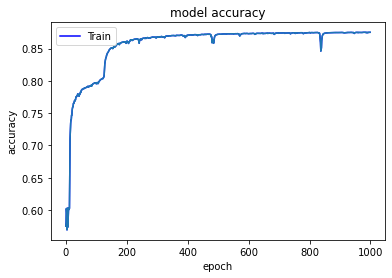

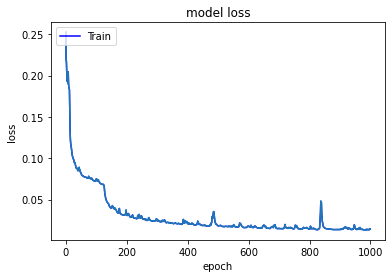

In [26]:
import matplotlib.pyplot as plt

# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()